In [1]:
%load_ext autoreload
%autoreload 2
from imports import *
import pickle

# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device("cuda:1")

In [17]:
from datasets.bdd_oia import BDD_OIA
image_dir = './data/bdd_oia/lastframe/data/'
label_dir = './data/bdd_oia/lastframe/labels/'

batch_size = 5

val_bdd_oia_dataset = BDD_OIA(image_dir,label_dir+'val_25k_images_actions.json',
                             label_dir+'val_25k_images_reasons.json')

val_loader = DataLoader(val_bdd_oia_dataset,shuffle=False,batch_size=batch_size,collate_fn=utils.collate_fn)

2259 2259 2259
number of samples in dataset:2259


## 1. Load model

In [18]:
def get_model(num_classes,image_mean,image_std):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True,
                                                                image_mean=image_mean,
                                                                image_std=image_std)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features,num_classes)
    return model

In [19]:
fastercnn = get_model(10,image_mean=val_bdd_oia_dataset.mean,image_std=val_bdd_oia_dataset.std)
checkpoint = torch.load('saved_models/bdd100k_24.pth')
fastercnn.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [20]:

# # Load version 1 
# from decision_generator_model import DecisionGenerator_v1
# decision_generator = DecisionGenerator_v1(fastercnn,device,batch_size)

# checkpoint = torch.load("saved_models/bdd_oia19.pth")
# decision_generator.load_state_dict(checkpoint["model"])


In [32]:

# Load version 2
from decision_generator_model import DecisionGenerator
decision_generator = DecisionGenerator(fastercnn,device,batch_size)

checkpoint = torch.load("saved_models/bdd_oia_sgd9.pth")
decision_generator.load_state_dict(checkpoint["model"])


<All keys matched successfully>

In [33]:
decision_generator = decision_generator.to(device)
decision_generator.eval()

DecisionGenerator(
  (rcnn): FasterRCNN(
    (transform): GeneralizedRCNNTransform(
        Normalize(mean=[102.9801, 115.9465, 122.7717], std=[1.0, 1.0, 1.0])
        Resize(min_size=(800,), max_size=1333, mode='bilinear')
    )
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d(64)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): FrozenBatchNorm2d(64)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): FrozenBatchNorm2d(64)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): FrozenBatchNor

## 2. Test

In [34]:
sample = next(iter(val_loader))
len(sample)

2

In [35]:
sample = next(iter(val_loader))
images, labels = sample


In [36]:
with open('./ce 597 demo/readme.txt') as f:
    txt = f.readlines()
all_reasons = np.array([lab.strip()[:-1] for lab in txt[6:-1]])
all_actions = np.array(['move forward', 'stop/slow down', 'turn left', 'turn right'])

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


In [37]:
action_batch = [all_actions[l['action'].numpy()==1] for l in labels]
reason_batch = [all_reasons[r['reason'].numpy()==1] for r in labels]
out = torchvision.utils.make_grid(list(images))


In [38]:
predictions = decision_generator(list(image.to(device) for image in images))


In [39]:
action_predicted_batch = predictions['action'].detach().cpu().numpy()>0.5
reason_predicted_batch = predictions['reasons'].detach().cpu().numpy()>0.5

action_predicted_batch = [all_actions[l] for l in action_predicted_batch]
reason_predicted_batch = [all_reasons[r] for r in reason_predicted_batch]

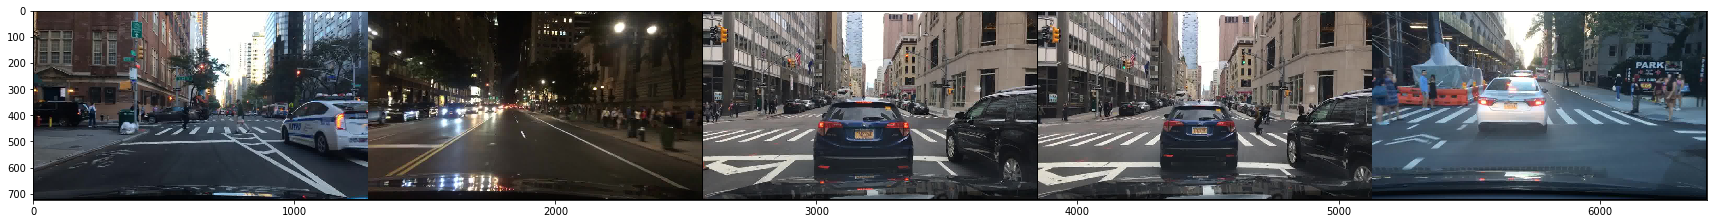

predicted actions:  ['move forward', 'turn left', 'turn right']
target actions:  ['stop/slow down']
predicted reasons:  ['f_road_clear: Forward - the road is clear', "no_l_solid_line - Can't turn left - solid line on the left", "no_r_solid_line - Can't turn right - solid line on the right"]
target reasons:  ['s_traffic_light: Stop/slow down - the traffic light', "no_l_lane - Can't turn left - no lane on the left", "no_r_car - Can't turn right - obstacles on the right lane"]

predicted actions:  ['move forward', 'turn left', 'turn right']
target actions:  ['move forward', 'turn right']
predicted reasons:  ['f_road_clear: Forward - the road is clear', "no_l_solid_line - Can't turn left - solid line on the left", "no_r_solid_line - Can't turn right - solid line on the right"]
target reasons:  ['f_road_clear: Forward - the road is clear', "no_l_lane - Can't turn left - no lane on the left"]

predicted actions:  ['move forward', 'turn left', 'turn right']
target actions:  ['stop/slow down']

In [40]:
plt.figure(figsize=(30,20))
imshow(out)

for a,b,ap,bp in zip(action_batch,reason_batch,action_predicted_batch,reason_predicted_batch):
    
    print("predicted actions: ", list(ap))
    print("target actions: ", list(a))

    print("predicted reasons: ", list(bp))
    print("target reasons: ", list(b))

    print()
    